#  3.Forward stepwise Regression for M+NH4

Number of rows after cleaning columns: 19
Number of columns after removing missing columns: 644


Performing Forward Stepwise Regression (R²):   0%| | 1/644 [00:00<06:00,  1.78it

Added Feature: GATS8m, R²: 0.6339


Performing Forward Stepwise Regression (R²):   0%| | 2/644 [00:01<06:10,  1.73it

Added Feature: WTPT-5, R²: 0.7580


Performing Forward Stepwise Regression (R²):   0%| | 3/644 [00:01<06:23,  1.67it

Added Feature: AATSC5c, R²: 0.8228


Performing Forward Stepwise Regression (R²):   1%| | 4/644 [00:02<06:40,  1.60it

Added Feature: GATS6s, R²: 0.8657


Performing Forward Stepwise Regression (R²):   1%| | 5/644 [00:03<07:03,  1.51it

Added Feature: GATS3p, R²: 0.9256


Performing Forward Stepwise Regression (R²):   1%| | 6/644 [00:03<07:25,  1.43it

Added Feature: GATS2p, R²: 0.9672


Performing Forward Stepwise Regression (R²):   1%| | 7/644 [00:04<08:00,  1.33it

Added Feature: topoShape, R²: 0.9787


Performing Forward Stepwise Regression (R²):   1%| | 7/644 [00:05<08:35,  1.24it


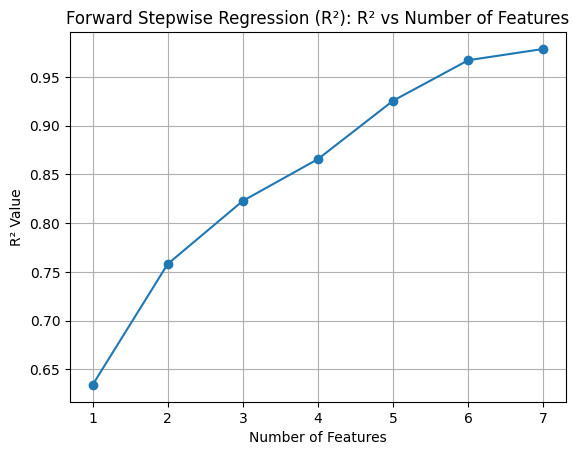

     Feature       Weight
0  Intercept    22.428331
1     GATS8m     5.510037
2     WTPT-5     1.810720
3    AATSC5c  4917.838114
4     GATS6s     5.973880
5     GATS3p   -21.546677
6     GATS2p    -6.073088
7  topoShape    -7.456442
Empty DataFrame
Columns: [Molecule, logRIE(PS), Outlier]
Index: []
Outliers found: 0


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import warnings
from tqdm import tqdm  # Progress bar
import matplotlib.pyplot as plt

# Suppress warnings
warnings.filterwarnings("ignore")

# Forward Stepwise Regression using R² for feature selection
def forward_selection_with_r2_threshold(X, y, r2_threshold=0.001):
    initial_features = []
    r2_values = []
    current_r2 = 0
    remaining_features = [col for col in X.columns if col not in initial_features]
    
    # Use tqdm to track progress
    with tqdm(total=len(remaining_features), desc="Performing Forward Stepwise Regression (R²)") as pbar:
        while True:
            remaining_features = [col for col in X.columns if col not in initial_features]
            new_r2 = pd.Series(index=remaining_features)
            for new_column in remaining_features:
                model = sm.OLS(y, sm.add_constant(X[initial_features + [new_column]])).fit()
                new_r2[new_column] = model.rsquared
            best_feature = new_r2.idxmax()
            best_r2 = new_r2.max()
            
            # Check if the improvement in R² is above the threshold
            if (best_r2 - current_r2) > r2_threshold:
                initial_features.append(best_feature)
                current_r2 = best_r2
                r2_values.append(current_r2)
                pbar.update(1)  # Update progress bar
                print(f"Added Feature: {best_feature}, R²: {current_r2:.4f}")
            else:
                break
    return initial_features, r2_values

# Load your dataset (replace 'your_file_path.xlsx' with the actual file path)
file_path = 'IE-training-file-standard-final.xlsx'
mh_sheet = pd.read_excel(file_path, sheet_name='M+NH4')

# Define the target variable (logRIE) and exclude unnecessary columns
exclude_columns = ['index', 'Molecule List', 'Molecule', 'SMILES', 'Adduct', 
                   'isotopic correction factor', 'Slope', 'RIE(PS)','logRIE(PS)'
                  ]

# Select relevant features and target
X = mh_sheet.drop(columns=exclude_columns)  # Drop logRIE(LPE) from features
y = mh_sheet['logRIE(PS)']  # Set logRIE(LPE) as the target

# Remove columns that have missing values (while keeping all rows)
X = X.dropna(axis=1)

# Ensure the number of rows in the dataset after cleaning columns
print(f"Number of rows after cleaning columns: {len(y)}")
print(f"Number of columns after removing missing columns: {X.shape[1]}")

# Perform Forward Stepwise Regression using R² with a threshold for improvement
selected_features_forward, r2_values_forward = forward_selection_with_r2_threshold(X, y, r2_threshold=0.01)

# Plot R² values against number of features
plt.plot(range(1, len(r2_values_forward) + 1), r2_values_forward, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('R² Value')
plt.title('Forward Stepwise Regression (R²): R² vs Number of Features')
plt.grid(True)
plt.show()

# Build the final model using the selected features
final_model = sm.OLS(y, sm.add_constant(X[selected_features_forward])).fit()

# Predict logRIE(LPE) values using the final model
y_pred = final_model.predict(sm.add_constant(X[selected_features_forward]))

# Extract the feature names and their corresponding coefficients (weights)
feature_weights = pd.DataFrame({
    'Feature': ['Intercept'] + selected_features_forward,
    'Weight': final_model.params.values
})

# Define the output file path (you can specify your preferred file path)
output_file_path = 'selected_features_and_weights-M-NH4.xlsx'

# Export to Excel file
feature_weights.to_excel(output_file_path, index=False)

# Optionally, display the DataFrame with the features and their weights
print(feature_weights)


# Calculate residuals (differences between actual and predicted values)
residuals = y - y_pred

# Define a threshold for outliers (e.g., residuals greater than 3 standard deviations from the mean)
threshold = 3 * np.std(residuals)

# Identify outliers
outliers = residuals.abs() > threshold

# Label outliers in the dataset using the 'Molecule' column
mh_sheet['Outlier'] = outliers

# Print the outliers with their corresponding 'Molecule' values
outliers_data = mh_sheet.loc[outliers, ['Molecule', 'logRIE(PS)', 'Outlier']]
print(outliers_data)

# Optionally, you can export the outlier data to a CSV file
outliers_data.to_csv('outliers_labeled.csv', index=False)

# Optionally, display the DataFrame with the labeled outliers
print("Outliers found:", outliers_data.shape[0])


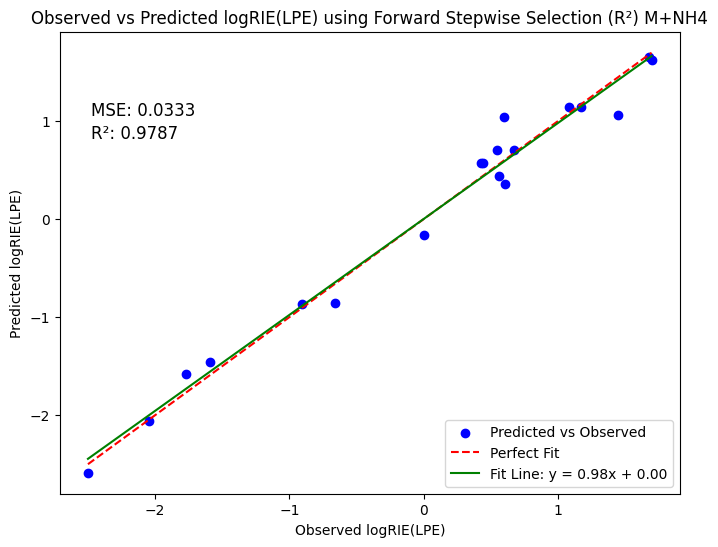

(['GATS8m', 'WTPT-5', 'AATSC5c', 'GATS6s', 'GATS3p', 'GATS2p', 'topoShape'],
 np.float64(0.9787403649779143))

In [2]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np

# Scatter plot of observed vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, color='blue', label='Predicted vs Observed')

# Perfect fit line
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Perfect Fit')

# Linear regression line
slope, intercept, r_value, p_value, std_err = linregress(y, y_pred)
line_x = np.linspace(y.min(), y.max(), 100)
line_y = slope * line_x + intercept
plt.plot(line_x, line_y, 'g-', label=f'Fit Line: y = {slope:.2f}x + {intercept:.2f}')

# Add annotations for MSE and R²
mse_full_data = ((y - y_pred) ** 2).mean()
r2_full_data = final_model.rsquared
plt.text(0.05, 0.85, f'MSE: {mse_full_data:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.80, f'R²: {r2_full_data:.4f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

# Labels and title
plt.xlabel('Observed logRIE(LPE)')
plt.ylabel('Predicted logRIE(LPE)')
plt.title('Observed vs Predicted logRIE(LPE) using Forward Stepwise Selection (R²) M+NH4')
plt.legend()
plt.show()

# Output selected features and R² value
selected_features_forward, r2_full_data


In [3]:
import pandas as pd
data_to_export = pd.DataFrame({'Observed': y, 'Predicted': y_pred})
data_to_export.to_csv('plot_data-M+NH4.csv', index=False)

In [3]:
import pandas as pd
data_to_export = pd.DataFrame({'Observed': y, 'Predicted': y_pred})
data_to_export.to_csv('plot_data-M+NH4.csv', index=False)

In [9]:
def generate_regression_equation(feature_weights):
    intercept = feature_weights.loc[feature_weights['Feature'] == 'Intercept', 'Weight'].values[0]
    terms = [f"{row['Weight']:.4f} * {row['Feature']}" for _, row in feature_weights.iterrows() if row['Feature'] != 'Intercept']
    return f"logRIE(LPE) = {intercept:.4f} + " + " + ".join(terms)

# Generate and display the equation
equation = generate_regression_equation(feature_weights)
print("Regression Model Equation:")
print(equation)

Regression Model Equation:
logRIE(LPE) = 22.4283 + 5.5100 * GATS8m + 1.8107 * WTPT-5 + 4917.8381 * AATSC5c + 5.9739 * GATS6s + -21.5467 * GATS3p + -6.0731 * GATS2p + -7.4564 * topoShape
